# Implementation of different versions of the benefit difference fairness function

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import multiprocessing as mp
from src.util import sigmoid
from src.feature_map import IdentityFeatureMap
from src.functions import cost_utility, demographic_parity
from src.plotting import plot_mean_over_lambdas, plot_median_over_lambdas
from src.training import train_multiple
from src.distribution import SplitDistribution, UncalibratedScore

## The parameters used by the the original authors  

In [2]:
bias = True
dim_x = 1
dim_theta = dim_x + 1 if bias else dim_x

lambdas = np.logspace(-1, 3, base=10, endpoint=True, num=100)
lambdas = np.insert(arr=lambdas, obj=0, values=[0.0])

iterations=30

def util_func(**util_params):
    util = cost_utility(cost_factor=0.1, **util_params)
    return util

training_parameters = {    
    'save_path': "/home/fkretschmar/Documents/master-thesis/res/exp-005/",
    'model':{
        'theta': [-3.0, 5.0],
        'benefit_value_function': demographic_parity,
        'utility_value_function': util_func,
        'feature_map': IdentityFeatureMap(dim_theta),
        'keep_collected_data': False,
        'use_sensitve_attributes': False,
        'bias': bias
    },
    'optimization': {
        'time_steps':200,
        'epochs': 128,
        'batch_size':256,
        'learning_rate': 1,
        'decay_rate': 1,
        'decay_step': 10000,
        'fairness_rates': lambdas,
        'test_at_every_timestep': False
    },
    'data': {
        'distribution': UncalibratedScore(bias=bias),
        'keep_data_across_lambdas': True,
        'fraction_protected':0.5,
        'num_test_samples': 8192,
        'num_decisions': 128 * 256
    }
}


## Correct Benefit Difference

0
------------------- Benefit Delta ----------------
Mean: 8.887642420937277e-05
Standard deviation: 0.0001886990702223971
First quartile: 0.0
Median: 0.0
Last quartile: 1.3981030037631982e-05
--------------------------------------------------
------------------- Lambda 24.201282647943835 -------------------
--------------------------------------------------
------------------- Utility ----------------------
Mean: 3.824869791666667e-05
Standard deviation: 7.66703496960539e-05
First quartile: 0.0
Median: 0.0
Last quartile: 5.493164062500001e-05
------------------- Benefit Delta ----------------
Mean: 8.166829401086657e-05
Standard deviation: 0.00014598273881409894
First quartile: 0.0
Median: 0.0
Last quartile: 0.000176163959504021
--------------------------------------------------
------------------- Lambda 26.560877829466868 -------------------
--------------------------------------------------
------------------- Utility ----------------------
Mean: 2.4414062500000005e-05
Standard dev

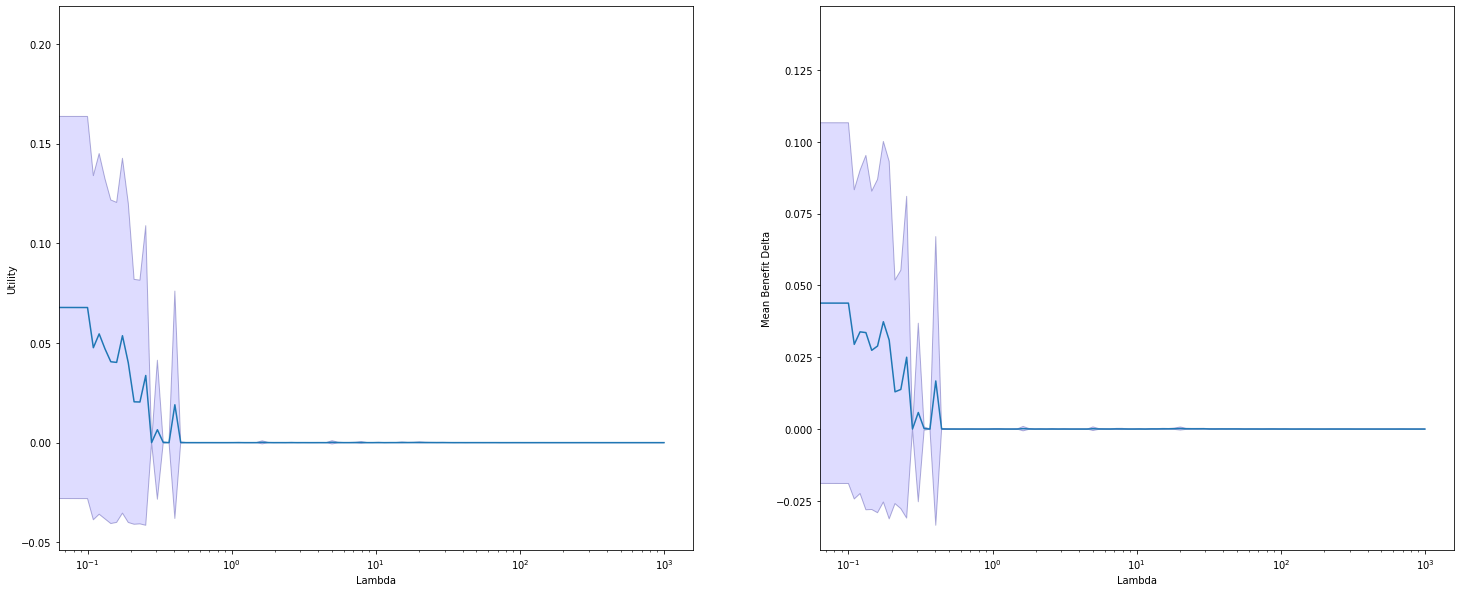

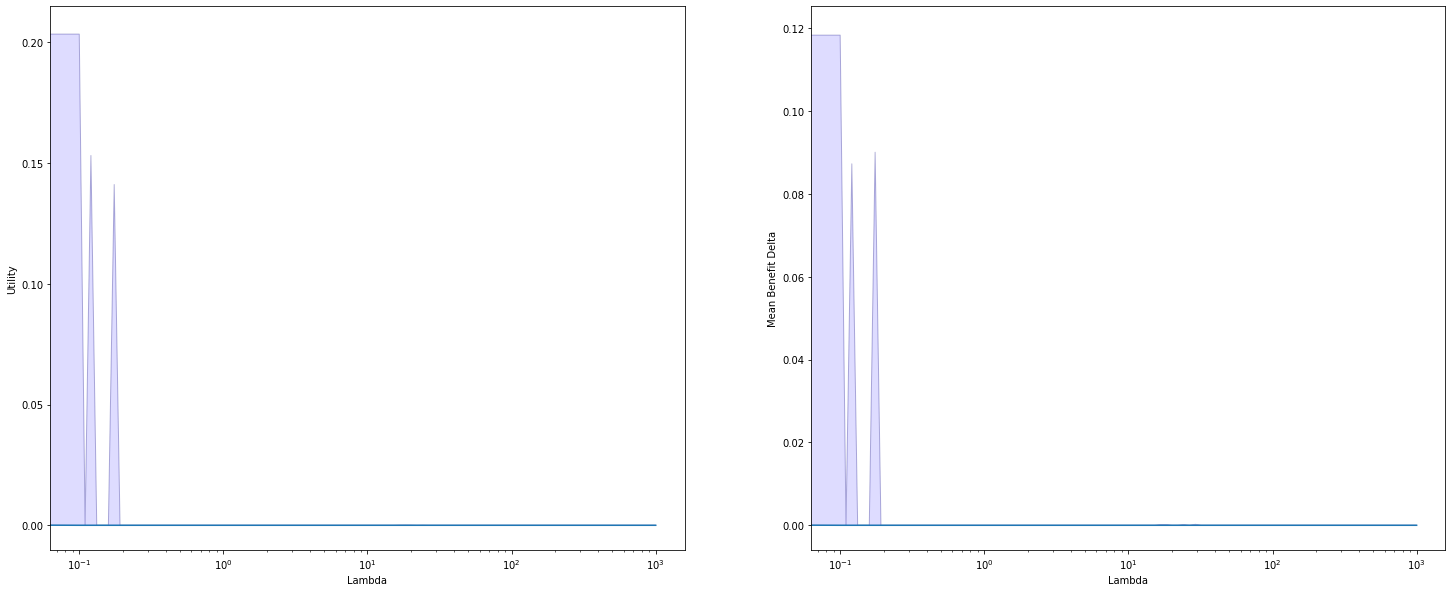

In [3]:
def fairness_function(**fairness_kwargs):
    policy = fairness_kwargs["policy"]
    x = fairness_kwargs["x"]
    s = fairness_kwargs["s"]
    y = fairness_kwargs["y"]
    decisions = fairness_kwargs["decisions"]
    ips_weights = fairness_kwargs["ips_weights"]

    benefit = policy.benefit_function(decisions=decisions, y=y)

    if ips_weights is not None:
        benefit *= ips_weights

    log_gradient = policy._log_gradient(x, s)
    benefit_grad = benefit * log_gradient
        
    # benefit-difference * grad-benefit-difference
    return policy._mean_difference(benefit, s) * policy._mean_difference(benefit_grad, s)

training_parameters["model"]['fairness_function'] = fairness_function

statistics = train_multiple(training_parameters, iterations=iterations, verbose=True, asynchronous=True)

plot_mean_over_lambdas(statistics, "/home/fkretschmar/Documents/master-thesis/res/exp-005/results_mean.png")
plot_median_over_lambdas(statistics, "/home/fkretschmar/Documents/master-thesis/res/exp-005/results_median.png")